## Zillow Kaggle Challenge EDA, 2017
Author: Man Peng

In [1]:
# -*- coding: utf-8 -*-
"""
2017 Zillow Kaggle Challenge

https://www.kaggle.com/c/zillow-prize-1

@author: MP
"""

import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats import kendalltau
import warnings
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import pylab
import gc

from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb
import logging
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

/home/aigscience/anaconda3/envs/dev36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Set global parameters
data_dir = os.path.join(os.getcwd(), "./source_data")
propertcsv = "properties_2016.csv"
traincsv = "train_2016_v2.csv"
submissioncsv = "sample_submission.csv"


# Load Data and EDA
property_df = pd.read_csv(os.path.join(data_dir, propertcsv))
train_df = pd.read_csv(os.path.join(data_dir, traincsv))
submission_df = pd.read_csv(os.path.join(data_dir, submissioncsv))

train = pd.merge(train_df, property_df, on="parcelid", how="left")

train["year"] = train.transactiondate.map(lambda x: str(x).split("-")[0])
train["year"] = pd.to_datetime(train['transactiondate'], format='%Y-%m-%d').dt.year
train["month"] = train.transactiondate.map(lambda x: str(x).split("-")[1])
train["day"] = train.transactiondate.map(lambda x: str(x).split("-")[2].split()[0])

/home/aigscience/anaconda3/envs/dev36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# add filemode="w" to overwrite
logging.basicConfig(filename="log.log", level=logging.INFO)
#logging.debug("This is a debug message")
logging.info("Logging starts...")
#logging.error("An error has happened!")

#### The train_df and property_df are the data frames from the source csv files, and train is the merged data frame from those two data frames.

## Data EDA and Visualization

In [4]:
# Data checks
submission_df.head()
print("Shape Of Train: ",train_df.shape)
print("Shape Of Properties: ",property_df.shape)
train.head(3).transpose()  # check the first few records in rotated view

Shape Of Train:  (90275, 3)
Shape Of Properties:  (2985217, 58)


,0,1,2
parcelid,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transactiondate,2016-01-01,2016-01-01,2016-01-01
airconditioningtypeid,1,NaN,1
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2,3.5,3
bedroomcnt,3,4,2
buildingclasstypeid,NaN,NaN,NaN
buildingqualitytypeid,4,NaN,4


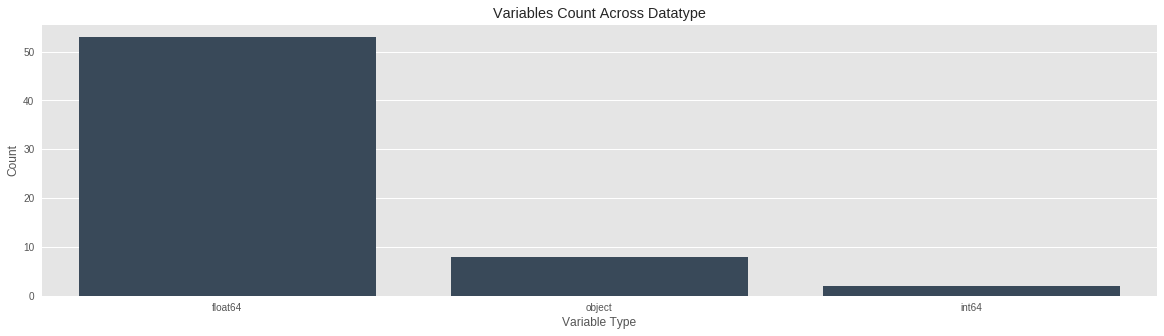

In [5]:
# Visualize the data
dataTypeDf = pd.DataFrame(train.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax,color="#34495e")
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")
sns.plt.show()

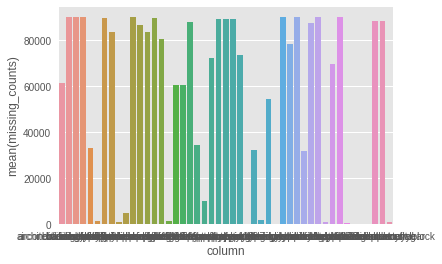

In [6]:
# Check the missing data
missingValueColumns = train.columns[train.isnull().any()].tolist()
miss_ = pd.DataFrame(train[missingValueColumns].apply(lambda x: np.sum(x.isnull()), axis=0))
miss_ = pd.DataFrame({"column" : miss_.index, "missing_counts": miss_[0].values})
ax = sns.barplot(x = "column", y = "missing_counts", data = miss_, estimator=np.mean)

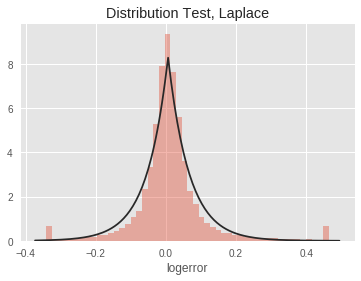

In [7]:
# Plot the distribution of the target value
ulimit = np.percentile(train.logerror.values, 99)
llimit = np.percentile(train.logerror.values, 1)
#train['logerror'].loc[train['logerror'] > ulimit] = ulimit
train_ = train.copy()
train_.loc[train_['logerror'] > ulimit, 'logerror'] = ulimit
train_.loc[train_['logerror'] < llimit, 'logerror'] = llimit

plt.figure(1)
ax = sns.distplot(train_['logerror'], kde=False, fit=st.laplace)
ax.set(xlabel='logerror', title="Distribution Test, Laplace")
sns.plt.show()

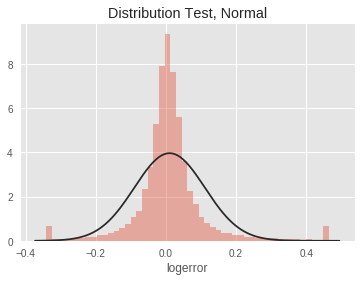

In [8]:
plt.figure(2); plt.title('Normal')
ax = sns.distplot(train_['logerror'], kde=False, fit=st.norm)
ax.set(xlabel='logerror', title="Distribution Test, Normal")
sns.plt.show()

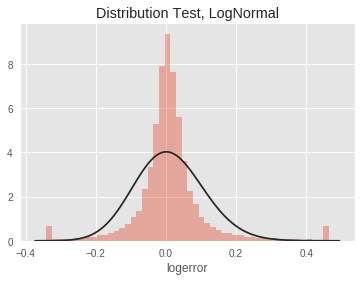

In [9]:
plt.figure(3); plt.title('LogNormal')
ax = sns.distplot(train_['logerror'], kde=False, fit=st.lognorm)
ax.set(xlabel='logerror', title="Distribution Test, LogNormal")
sns.plt.show()

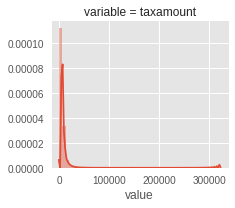

In [10]:
f = pd.melt(train_, value_vars=["taxamount"])
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
sns.plt.show()

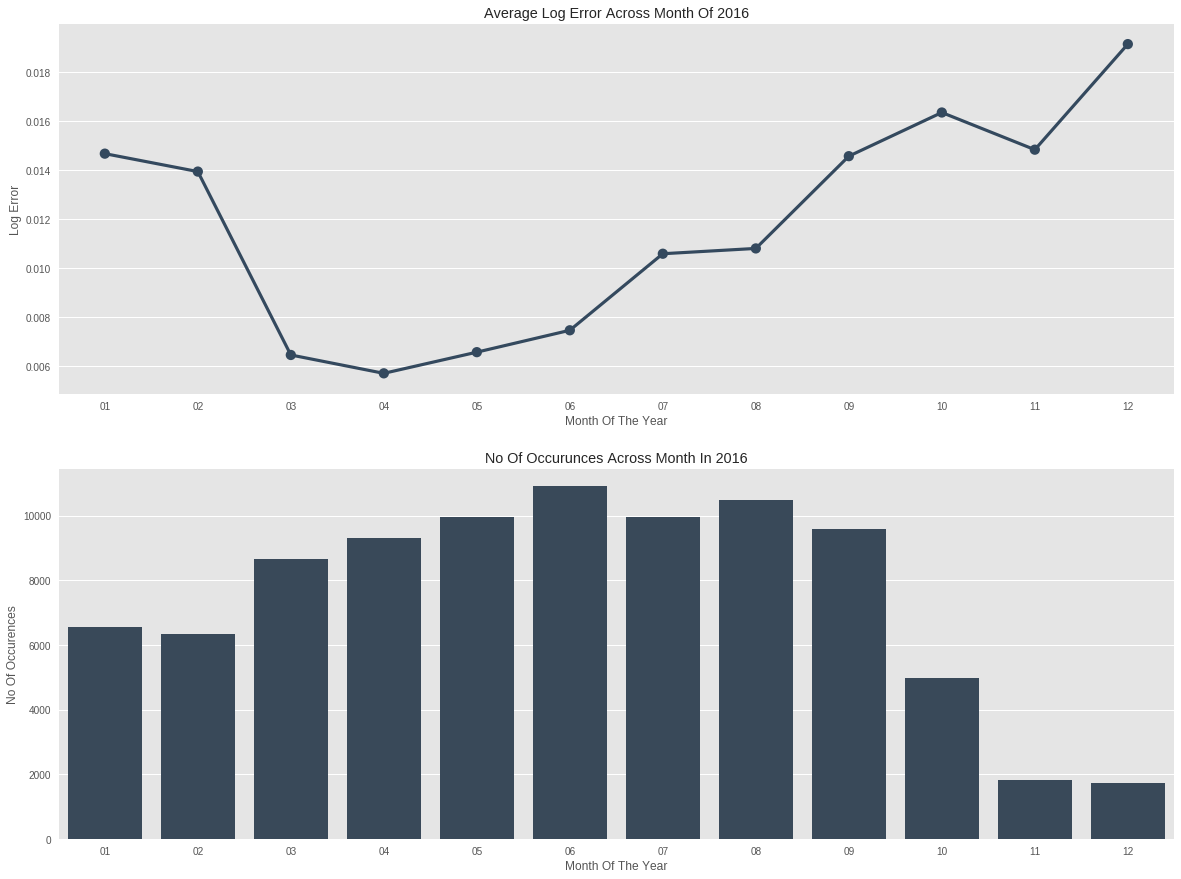

In [11]:
# Bivariate Analysis
traingroupedMonth = train_.groupby(["month"])["logerror"].mean().to_frame().reset_index()
traingroupedDay = train_.groupby(["day"])["logerror"].mean().to_frame().reset_index()
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)
sns.pointplot(x=traingroupedMonth["month"], y=traingroupedMonth["logerror"], data=traingroupedMonth, join=True,ax=ax1,color="#34495e")
ax1.set(xlabel='Month Of The Year', ylabel='Log Error',title="Average Log Error Across Month Of 2016",label='big')
sns.countplot(x=train_["month"], data=train_,ax=ax2,color="#34495e")
ax2.set(xlabel='Month Of The Year', ylabel='No Of Occurences',title="No Of Occurunces Across Month In 2016",label='big')
sns.plt.show()

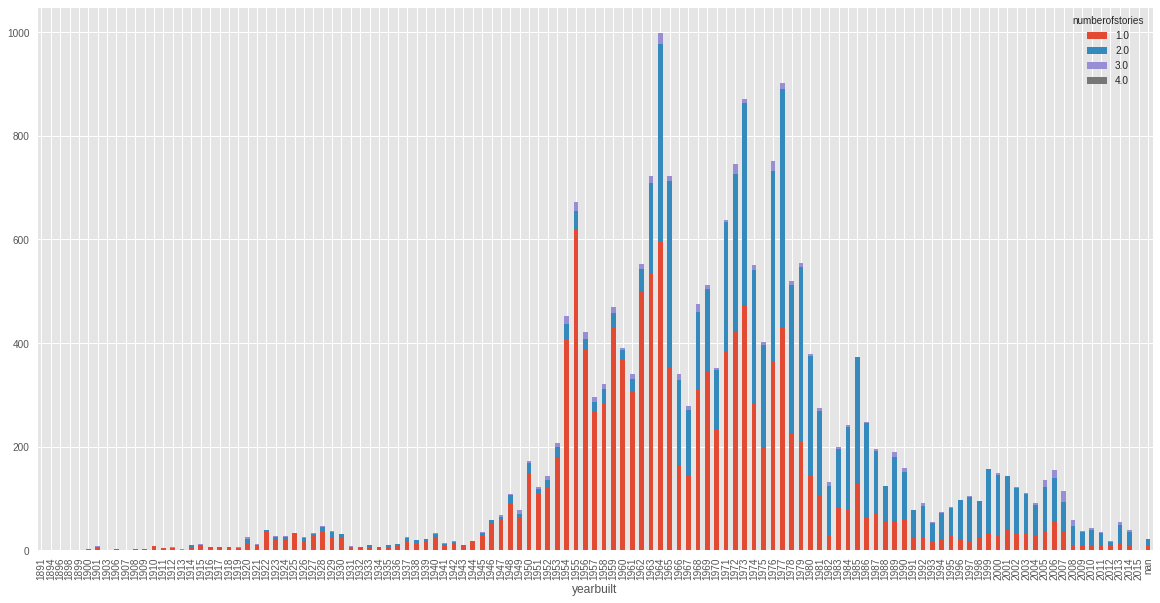

In [12]:
# Check the number of stories distribution by year of built
fig,ax1= plt.subplots()
fig.set_size_inches(20,10)
train["yearbuilt"] = train["yearbuilt"].map(lambda x: str(x).split(".")[0])
yearMerged = train.groupby(['yearbuilt', 'numberofstories'])["parcelid"].count().unstack('numberofstories').fillna(0)
yearMerged.plot(kind='bar', stacked=True,ax=ax1)
sns.plt.show()

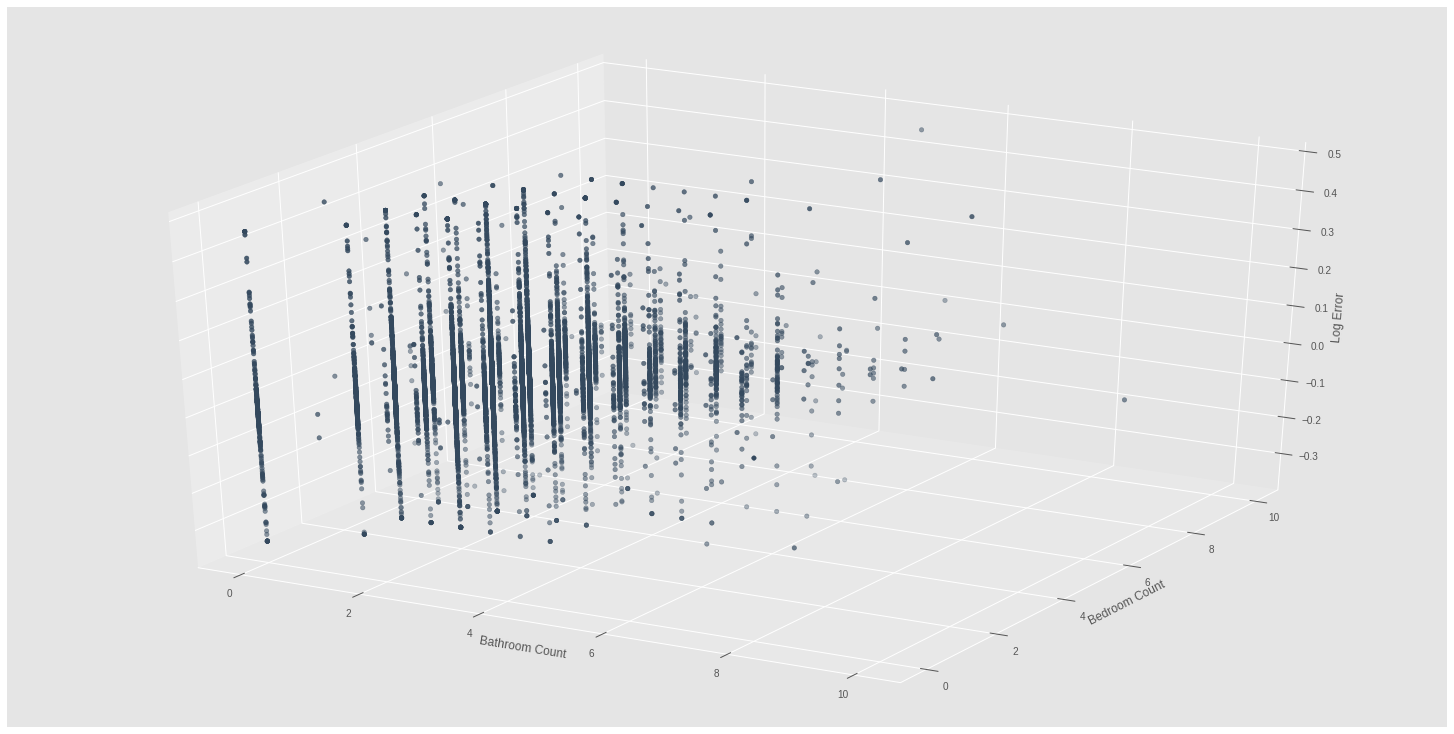

In [13]:
# Set capping and flooring for the numerical variables
cols = ["bathroomcnt","bedroomcnt","roomcnt","numberofstories","logerror","calculatedfinishedsquarefeet"]
mergedFiltered = train_[cols].dropna()
for col in cols:
    ulimit = np.percentile(train[col].dropna().values, 99.5)
    llimit = np.percentile(train[col].dropna().values, 0.5)
    train_.loc[train_[col]>ulimit, col] = ulimit
    train_.loc[train_[col]<llimit, col] = llimit

# 3D plot on the (Bedroom Count + Bathroom Count) vs (LogError)
fig = pylab.figure()
fig.set_size_inches(20,10)
ax = Axes3D(fig)
ax.scatter(mergedFiltered.bathroomcnt, mergedFiltered.bedroomcnt, mergedFiltered.logerror,color="#34495e")
ax.set_xlabel('Bathroom Count')
ax.set_ylabel('Bedroom Count')
ax.set_zlabel('Log Error')
plt.show()

del train_

## Variable Importance by XGBoost

In [6]:
# Label Encoder
str_predictors_to_exclude = []
for f in train.columns:
    if train[f].dtype=='object':
        print("Label encoding variable " + f + "...")
        str_predictors_to_exclude.append(f)
        values_ = train[f].astype(str).fillna('nan')
        values_ = np.sort(values_)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(values_) 
        train[f+'_encode'] = lbl.transform(train[f].astype(str).fillna('nan'))

Label encoding variable transactiondate...
Label encoding variable hashottuborspa...
Label encoding variable propertycountylandusecode...
Label encoding variable propertyzoningdesc...
Label encoding variable fireplaceflag...
Label encoding variable taxdelinquencyflag...
Label encoding variable month...
Label encoding variable day...


In [7]:
def newlog(x):
    x2 = np.array(x).astype(np.float64)
    if np.nanmin(x2) <= 0:
        x2 = x2 - np.nanmin(x2) + 1
    return np.log(x2)

In [8]:
# log numerical variables
num_predictors = []
columns_ = train.columns
for f in columns_:
    if f in ["transactiondate_encode", "parcelid", "transactiondate", "logerror",
            "airconditioningtypeid", "architecturalstyletypeid",
            "assessmentyear", "bathroomcnt", "buildingclasstypeid",
            "calculatedbathnbr", "decktypeid", "regionidzip",
            "roomcnt", "storytypeid", "taxdelinquencyyear",
            "typeconstructiontypeid", "unitcnt", "fullbathcnt",
            "fips", "garagecarcnt", "heatingorsystemtypeid",
            "numberofstories", "poolcnt", "pooltypeid10",
            "pooltypeid2", "pooltypeid7", "propertylandusetypeid",
            "rawcensustractandblock", "regionidcity", "regionidneighborhood"]:
        next
    else:
        if train[f].dtype in ['float64', 'float32']:
            print("Taking log of variable " + f + "...")
            num_predictors.append(f)
            if np.sum(train[f] < 0) == 0:
                train[f+'_log'] = newlog(train[f].values)

Taking log of variable basementsqft...
Taking log of variable bedroomcnt...
Taking log of variable buildingqualitytypeid...
Taking log of variable finishedfloor1squarefeet...
Taking log of variable calculatedfinishedsquarefeet...
Taking log of variable finishedsquarefeet12...
Taking log of variable finishedsquarefeet13...
Taking log of variable finishedsquarefeet15...
Taking log of variable finishedsquarefeet50...
Taking log of variable finishedsquarefeet6...
Taking log of variable fireplacecnt...
Taking log of variable garagetotalsqft...
Taking log of variable latitude...
Taking log of variable longitude...
Taking log of variable lotsizesquarefeet...
Taking log of variable poolsizesum...
Taking log of variable regionidcounty...
Taking log of variable threequarterbathnbr...
Taking log of variable yardbuildingsqft17...
Taking log of variable yardbuildingsqft26...
Taking log of variable yearbuilt...
Taking log of variable structuretaxvaluedollarcnt...
Taking log of variable taxvaluedolla

In [9]:
predictors = np.setdiff1d(train.columns.values,
                         ["transactiondate_encode", "parcelid", \
                          "transactiondate", "logerror", \
                         "logerror_log"] + str_predictors_to_exclude)
train_y = train.logerror.values
#train_X = train.drop(["parcelid", "transactiondate", "logerror"], axis=1)
train_X = train[predictors]

# predictors2 is the list of predictors after variable selection
# if predictors2 is not None: train_X = train[predictors2]

In [12]:
# So far, the 30, 30 is the best alpha, lambda values
for alpha_ in [100, 30, 10, 3, 1, 0.3, 0.1]:
    for lambda_ in [100, 30, 10, 3, 1, 0.3, 0.1]:
        xgb_params = {
            'eta': 0.1,
            'max_depth': 10,
            'subsample': 0.5,
            'colsample_bytree': 0.8,
            'objective': 'reg:linear',
            'eval_metric': 'mae',  # since it's closer to laplace distribution, also because this is competition metric
            'silent': 0,
            'alpha': alpha_,
            'lambda': lambda_
        }

        dtrain = xgb.DMatrix(train_X, label=train_y, feature_names = train_X.columns.values, missing = np.nan)
        # The xgb.cv is very useful for tuning parameters
        model_v01 = xgb.cv(xgb_params, dtrain, num_boost_round=5000, nfold=10, seed = 10011,
                           callbacks=[xgb.callback.print_evaluation(period=200, show_stdv=False),
                             xgb.callback.early_stop(stopping_rounds=20, maximize=False, verbose=True)])

        # print("The class of the model_v01 from xgb.cv is " + str(model_v01.__class__))

        gc.collect()
        logging.info("The test-mae is {} with alpha {}, lambda {}".format(model_v01['test-mae-mean'][-1:].values[0],
                                                alpha_, lambda_))
        print("The test-mae is {} with alpha {}, lambda {}".format(model_v01['test-mae-mean'][-1:].values[0],
                                                alpha_, lambda_))

[0]	train-mae:0.449012	test-mae:0.449023
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 20 rounds.
Stopping. Best iteration:
[83]	train-mae:0.0678669+0.000197034	test-mae:0.0683062+0.00156687

The test-mae is 0.0683062 with alpha 30, lambda 30


##### Variable Selection

In [135]:
np.random.seed(10011)
x = pd.DataFrame()
x['random_1'] = np.random.uniform(0,1,size=10)
x['random_2'] = np.random.normal(0,1,size=10)
train_X = pd.concat([train[predictors], x], axis=1)

xgb_params = {
            'eta': 0.1,
            'max_depth': 10,
            'subsample': 0.5,
            'colsample_bytree': 0.8,
            'objective': 'reg:linear',
            'eval_metric': 'mae',  # since it's closer to laplace distribution, also because this is competition metric
            'silent': 0,
            'alpha': 30,
            'lambda': 30
        }

dtrain = xgb.DMatrix(train_X, label=train_y, feature_names = train_X.columns.values, missing = np.nan)
watchlist = [(dtrain,"eval"), (dtrain,"train")]
model_ = xgb.train(xgb_params, dtrain, num_boost_round=300, evals=watchlist)

[0]	eval-mae:0.449032	train-mae:0.449032
[1]	eval-mae:0.406138	train-mae:0.406138
[2]	eval-mae:0.36769	train-mae:0.36769
[3]	eval-mae:0.333312	train-mae:0.333312
[4]	eval-mae:0.302532	train-mae:0.302532
[5]	eval-mae:0.275085	train-mae:0.275085
[6]	eval-mae:0.250565	train-mae:0.250565
[7]	eval-mae:0.228755	train-mae:0.228755
[8]	eval-mae:0.209182	train-mae:0.209182
[9]	eval-mae:0.191793	train-mae:0.191793
[10]	eval-mae:0.176454	train-mae:0.176454
[11]	eval-mae:0.162706	train-mae:0.162706
[12]	eval-mae:0.150516	train-mae:0.150516
[13]	eval-mae:0.139671	train-mae:0.139671
[14]	eval-mae:0.130134	train-mae:0.130134
[15]	eval-mae:0.121766	train-mae:0.121766
[16]	eval-mae:0.114373	train-mae:0.114373
[17]	eval-mae:0.107977	train-mae:0.107977
[18]	eval-mae:0.102408	train-mae:0.102408
[19]	eval-mae:0.097591	train-mae:0.097591
[20]	eval-mae:0.093391	train-mae:0.093391
[21]	eval-mae:0.089733	train-mae:0.089733
[22]	eval-mae:0.086588	train-mae:0.086588
[23]	eval-mae:0.083901	train-mae:0.083901
[24]

In [152]:
xgb_importance = pd.DataFrame([model_.get_score()]).transpose()
xgb_importance['variable_name'] = xgb_importance.index
xgb_importance['score'] = xgb_importance[0]
xgb_importance = xgb_importance.drop([0], axis = 1)
xgb_importance.reset_index()
xgb_importance = xgb_importance.sort_values(ascending=False, by="score")
xgb_importance.variable_name.values
invalid_vars = ["airconditioningtypeid_log", "architecturalstyletypeid_log",
                "assessmentyear_log", "bathroomcnt_log", "buildingclasstypeid_log",
                "calculatedbathnbr_log", "decktypeid_log", "regionidzip_log",
                "roomcnt_log", "storytypeid_log", "taxdelinquencyyear_log",
                "typeconstructiontypeid_log", "unitcnt_log", "fullbathcnt_log",
                "fips_log", "garagecarcnt_log", "heatingorsystemtypeid_log",
                "numberofstories_log", "poolcnt_log", "pooltypeid10_log",
                "pooltypeid2_log", "pooltypeid7_log", "propertylandusetypeid_log",
                "rawcensustractandblock_log", "regionidcity_log", "regionidneighborhood_log"]
predictors2 = np.setdiff1d(xgb_importance.variable_name.values, invalid_vars)

In [ ]:
# CV model
model = xgb.XGBRegressor()
kfold = KFold(n_splits=10, random_state=10011)

if "DataFrame" in str(train_X.__class__):
    train_X = train_X.fillna(0).as_matrix()

foldid = 1
error_test_final = 0
xgb_models = []

# Start the Cross Validation
for train_index, test_index in kfold.split(train_X):
    if foldid > 2: break
    xgb_model = xgb.XGBRegressor(
                    max_depth=10,
                    learning_rate=0.1,
                    n_estimators=5000,
                    silent=False,
                    objective='reg:linear',
                    #booster='gbtree',
                    nthread=4,  # number of threads in the job
                    min_child_weight=1,
                    subsample=0.5,
                    colsample_bytree=0.8,
                    colsample_bylevel=0.8,
                    reg_alpha=100,
                    reg_lambda=100,
                    scale_pos_weight=1,
                    seed=10011,
                    missing=None)
    
    xgb_models += [xgb_model]
    xgb_model.fit(train_X[train_index],train_y[train_index],
                  eval_set=[(train_X[train_index], train_y[train_index]), (train_X[test_index], train_y[test_index])],
                  eval_metric="mae",
                  early_stopping_rounds=20,
                  verbose=False)
    predictions = xgb_model.predict(train_X)
    error_test = mean_absolute_error(train_y[test_index], predictions[test_index])
    error_train = mean_absolute_error(train_y[train_index], predictions[train_index])
    error_test_final += error_test
    print("*"*80)
    print("The train-mae is {} and test-mae is {} for foldid {}".format(round(error_train, 6), round(error_test, 6), foldid))
    print("*"*80)
    if foldid == kfold.n_splits:
        print("The cross-validated test-mae is {} through {} folds".format(round(error_test_final/kfold.n_splits, 6), kfold.n_splits))
    foldid += 1

gc.collect()

In [ ]:
print("*"*80)